In [1]:
import numpy as np

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt


In [4]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [5]:
scores_list = []

In [6]:
with open("gen_5000_0.5_loss_10_5000000.0_0.06857646597707703.pkl", 'rb') as handle:
    scores = pickle.load(handle)
scores_list.append(scores)
scores.shape

(1000, 5000)

In [7]:
with open("gen_5000_0.5_loss_100_5000000.0_0.13484593435394499.pkl", 'rb') as handle:
    scores = pickle.load(handle)
scores_list.append(scores)
scores.shape

(1000, 5000)

In [8]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [9]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-gen.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

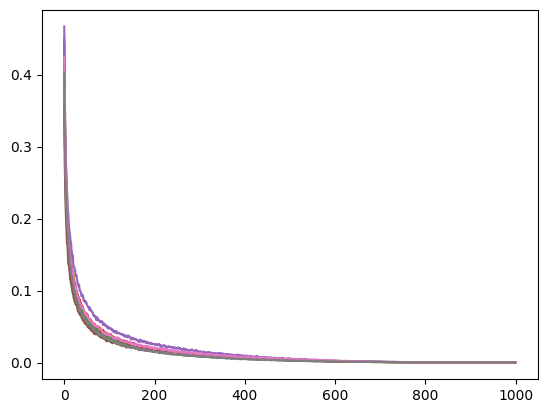

In [10]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [11]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [12]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

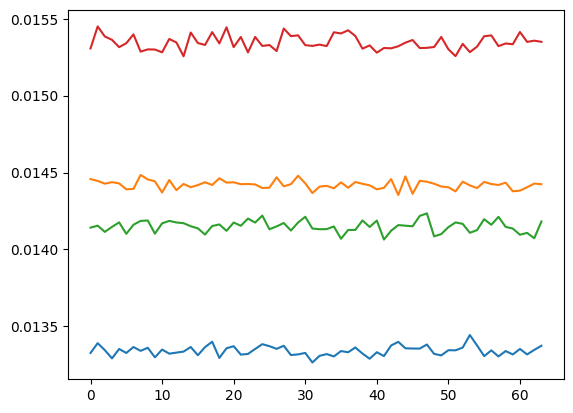

In [13]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [14]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_list[0]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

# tmp_1 = rs

Correlation: 0.069 (avg p value 0.454842)


In [15]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_list[1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

# tmp_1 = rs

Correlation: 0.135 (avg p value 0.351265)


In [16]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [17]:
res_list = []
for i in range(2):
    print(i)
    def my_statistics(data):
        # print(data)
        # print(len(data))
        margins = lds_testset_correctness[data]
        infl_est_ = -scores_list[i]
        # infl_est_ = -tmp
        preds = lds_mask_array[data] @ infl_est_.T
        ####
        rs = []
        ps = []
        for ind in range(1000):
            r, p = spearmanr(preds[:, ind], margins[:, ind])
            # r, p = pearsonr(preds[:, ind], margins[:, ind])
            rs.append(r)
            ps.append(p)
        
        rs, ps = np.array(rs), np.array(ps)
        # print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    
        return rs.mean()     

    data = (list(range(64)), )  # samples must be in a sequence
    res = bootstrap(data, my_statistics, 
                    n_resamples=64, # 够了估计
                    batch=128,
                    confidence_level=0.95,
                    random_state=42)

    print(res.confidence_interval)
    
    print(res.confidence_interval.low.round(3))
    print(res.confidence_interval.high.round(3))

    res_list.append(res)
    # break

0
ConfidenceInterval(low=0.05447080465592102, high=0.08176796472897989)
0.054
0.082
1
ConfidenceInterval(low=0.1261858371161179, high=0.15086119000817264)
0.126
0.151


In [18]:
with open("./gen_res_list.pkl", 'wb') as handle:
    pickle.dump([[res.confidence_interval.low, res.confidence_interval.high, res.bootstrap_distribution, res.standard_error] for res in res_list],
                handle)

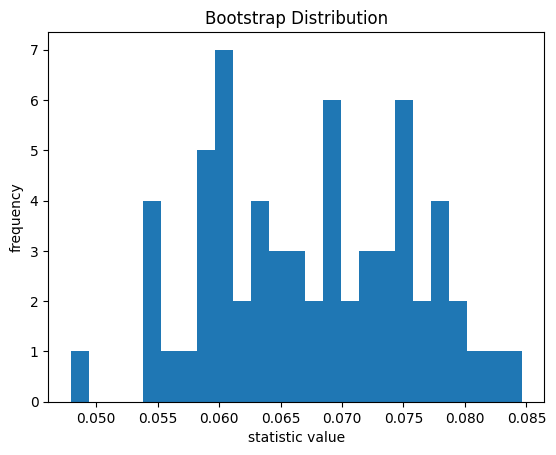

In [19]:
fig, ax = plt.subplots()
ax.hist(res_list[0].bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()